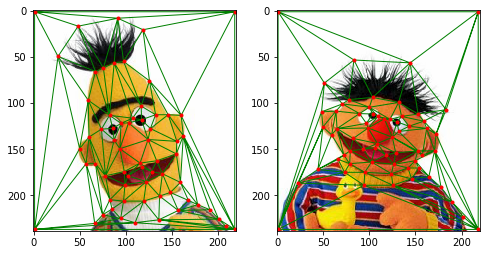

# Face Morphing and Swapping

In this project, I developed a function to warp from one face to another using the piecewise affine warping technique and use it to perform morphing and face-swapping. 

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

#part 2
from matplotlib.path import Path
from scipy.spatial import Delaunay
from a5utils import bilinear_interpolate

#part 2 demo for displaying animations in notebook
from IPython.display import HTML
from a5utils import display_movie

#part 4 blending
from scipy.ndimage import gaussian_filter

---
# Part 1 - Transforming Triangles

The function ***get_transform*** takes the corner coordinates of two triangles and computes an affine transformation (represented as a 3x3 matrix) that maps the vertices of a given source triangle to the specified target position. We will use this to map pixels inside each triangle of our mesh. For convenience, the function ***apply_transform*** takes a transformation (3x3 matrix) and a set of points, and transforms the points. 

In [2]:
def get_transform(pts_source,pts_target):
    """
    This function takes the coordinates of 3 points (corners of a triangle)
    and a target position and estimates the affine transformation needed
    to map the source to the target location.
    
    
    Parameters
    ----------
    pts_source : 2D float array of shape 2x3
         Source point coordinates
    pts_target : 2D float array of shape 2x3
         Target point coordinates
   
    Returns
    -------
    T : 2D float array of shape 3x3
        the affine transformation
    """
    
    assert(pts_source.shape==(2,3))
    assert(pts_target.shape==(2,3))
    
    pts_s = np.append(pts_source, [[1,1,1]], axis=0)
    pts_t = np.append(pts_target, [[1,1,1]], axis=0)
    
    T = np.dot(pts_t,np.linalg.inv(pts_s))
    
    return T


def apply_transform(T,pts):
    """
    This function takes the coordinates of a set of points and
    a 3x3 transformation matrix T and returns the transformed
    coordinates
    
    
    Parameters
    ----------
    T : 2D float array of shape 3x3
         Transformation matrix
    pts : 2D float array of shape 2xN
         Set of points to transform
   
    Returns
    -------
    pts_warped : 2D float array of shape 2xN
        Transformed points
    """

    assert(T.shape==(3,3))
    assert(pts.shape[0]==2)
    
    # convert to homogenous coordinates, multiply by T, convert back
    pts1 = np.append(pts,np.ones((1,pts.shape[1])),axis=0)
    pts_warped = np.dot(T,pts1)
    pts_warped = np.delete(pts_warped, 2, 0)
    
    return pts_warped

In [3]:
#
# some test cases for affine_transform function
#

# check that using the same source and target should yield identity matrix
src = np.random.random((2,3))
targ = src
print(get_transform(src,targ)-np.identity(3)<1e-12)

# check that if targ is just a translated version of src, then the translation
# appears in the expected locations in the transformation matrix
src = np.random.random((2,3))
targ = src + np.ones((2,3))*10
print(get_transform(src,targ).round(0))

# random tests... check that for two random 
# triangles the estimated transformation correctly
# maps one to the other
for i in range(5):
    src = np.random.random((2,3))
    targ = np.random.random((2,3))
    T = get_transform(src,targ)
    targ1 = apply_transform(T,src)
    assert(np.sum(np.abs(targ-targ1))<1e-12)
    print('passed test: ',i+1)
   

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ 1.  0. 10.]
 [ 0.  1. 10.]
 [ 0.  0.  1.]]
passed test:  1
passed test:  2
passed test:  3
passed test:  4
passed test:  5


---

orig|warped
-|-
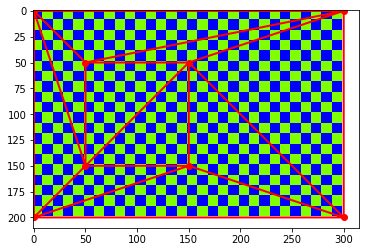 | 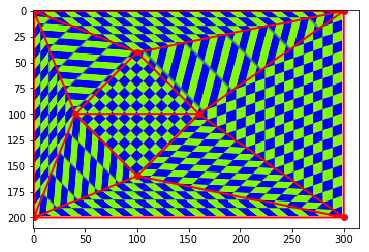

# Part 2 - Piecewise Affine Warping 

The function called ***warp*** performs piecewise affine warping of the image. The function takes a source image, a set of triangulated points in the source image and a set of target locations for those points. We will acomplish this using *backwards warping* in the following steps:

1. For each pixel in the warped output image, we first need to determine which triangle it falls inside of. The code builds an array ***tindex*** which is the same size as the input image where ***tindex[i,j]=t*** if pixel ***[i,j]*** falls inside triangle ***t***. Pixels which are not in any triangle should have a ***tindex*** value of -1. I implement my own point-in-triangle check (there are several ways to do it, see e.g.,
http://www.jeffreythompson.org/collision-detection/tri-point.php) Alternately, we can use ***matplotlib.path.Path.contains_points*** which checks whether a point falls inside a specified polygon.


2. For each triangle, use the ***get_transform*** function from Part 1 to compute the affine transformation that maps the pixels in the output image back to the source image (i.e., mapping pts_target to pts_source for the triangle). Apply the estimated transform to the coordinates of all the pixels in the output triangle to determine their locations in the input image.


3. Finally I use bilinear interpolation to determine the colors of the output pixels. The code in ***a5utils.py*** contains a function ***bilinear_interpolate*** that implements the interpolation. To handle color images, 23 will need to call ***bilinear_interpolate*** three times for the R, G and B color channels separately.


In [4]:
def warp(image,pts_source,pts_target,tri):
    
    """
    This function takes a color image, a triangulated set of keypoints
    over the image, and a set of target locations for those points.
    The function performs piecewise affine wapring by warping the 
    contents of each triangle to the desired target location and 
    returns the resulting warped image.
    
    Parameters
    ----------
    image : 3D float array of shape HxWx3
         An array containing a color image
    
    pts_src: 2D float array of shape 2xN
        Coordinates of N points in the image
        
    pts_target: 2D float array of shape 2xN
        Coorindates of the N points after warping
        
    tri: 2D int array of shape Ntrix3
        The indices of the pts belonging to each of the Ntri triangles
        
    Returns
    -------
    warped_image : 3D float array of shape HxWx3
        resulting warped image
    
    tindex : 2D int array of shape HxW
        array with values in 0...Ntri-1 indicating which triangle 
        each pixel was contained in (or -1 if the pixel is not in any triangle)
    """   

    assert(image.shape[2]==3) #this function only works for color images
    assert(tri.shape[1]==3)   #each triangle has 3 vertices
    assert(pts_source.shape==pts_target.shape)
    assert(np.max(image)<=1)  #image should be float with RGB values in 0..1
    
    ntri = tri.shape[0]
    (h,w,d) = image.shape

    # for each pixel in the target image, figure out which triangle
    # it fall in side of so we know which transformation to use for
    # those pixels.
    #
    # tindex[i,j] should contain a value in 0..ntri-1 indicating which
    # triangle contains pixel (i,j).  set tindex[i,j]=-1 if (i,j) doesn't
    # fall inside any triangle
    tindex = -1*np.ones((h,w))
    xx,yy = np.mgrid[0:h,0:w]
    pcoords = np.stack((yy.flatten(),xx.flatten()),axis=1)
    for t in range(ntri):
        corners = pts_target[:,tri[t]]  #get vertices of triangle t. 
        #create a boolean array where mask[i]=True if pcoords[i] is in the triangle
        mask = Path(corners.T).contains_points(pcoords) 
        mask = mask.reshape(h,w)
        #set tindex[i,j]=t any where that mask[i,j]=True
        tindex[np.where(mask==1)] = t
    
    # compute the affine transform associated with each triangle that
    # maps a given target triangle back to the source coordinates
    
#     tindex = tindex.astype(int)
    
    Xsource = np.zeros((2,h*w))  #source coordinate for each output pixel
    tindex_flat = tindex.flatten() #flattened version of tindex as an h*w length vector
 
    for t in range(ntri):
        #coordinates of target/output vertices of triangle t
        ptarg = pts_target[:,tri[t]] 
        
        #coordinates of source/input vertices of triangle t
        psrc = pts_source[:,tri[t]]   
        
        #compute transform from ptarg -> psrc
        T = get_transform(ptarg,psrc)
        
        #extract coordinates of all the pixels where tindex==t
        pcoords_t = pcoords[tindex_flat==t]
#         print(pcoords_t)
        
        #store the transformed coordinates at the correspondiong locations in Xsource
        Xsource[:,tindex_flat==t] = apply_transform(T,pcoords_t.T)
    
    # now use interpolation to figure out the color values at locations Xsource     
    warped_image = np.zeros(image.shape)
    warped_image[:,:,0] = bilinear_interpolate(image[:,:,0],Xsource[0,:],Xsource[1,:]).reshape(h,w)
    warped_image[:,:,1] = bilinear_interpolate(image[:,:,1],Xsource[0,:],Xsource[1,:]).reshape(h,w)
    warped_image[:,:,2] = bilinear_interpolate(image[:,:,2],Xsource[0,:],Xsource[1,:]).reshape(h,w)
    
    # clip RGB values outside the range [0,1] to avoid warning messages
    # when displaying warped image later on
    warped_image = np.clip(warped_image,0.,1.)

    return (warped_image,tindex)

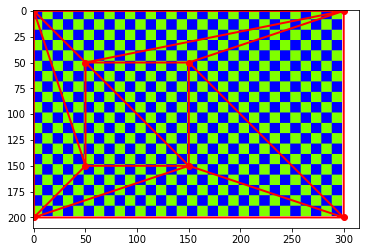

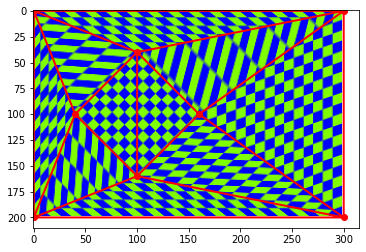

<Figure size 298x198 with 0 Axes>

In [5]:
#
# Test warp function
#

#make a color checkerboard image
(xx,yy) = np.mgrid[1:200,1:300]
G = np.mod(np.floor(xx/10)+np.floor(yy/10),2)
B = np.mod(np.floor(xx/10)+np.floor(yy/10)+1,2)
image = np.stack((0.5*G,G,B),axis=2)

#coordinates of the image corners
pts_corners = np.array([[0,300,300,0],[0,0,200,200]])

#points on a square in the middle + image corners
pts_source = np.array([[50,150,150,50],[50,50,150,150]])
pts_source = np.concatenate((pts_source,pts_corners),axis=1)

#points on a diamond in the middle + image corners
pts_target = np.array([[100,160,100,40],[40,100,160,100]])
pts_target = np.concatenate((pts_target,pts_corners),axis=1)

#compute triangulation using mid-point between source and
#target to get triangles that are good for both.
pts_mid = 0.5*(pts_target+pts_source)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# display initial image
plt.imshow(image)
plt.triplot(pts_source[0,:],pts_source[1,:],tri,color='r',linewidth=2)
plt.plot(pts_source[0,:],pts_source[1,:],'ro')
plt.show()

# display warped image
(warped,tindex) = warp(image,pts_source,pts_target,tri)
plt.imshow(warped)
plt.triplot(pts_target[0,:],pts_target[1,:],tri,color='r',linewidth=2)
plt.plot(pts_target[0,:],pts_target[1,:],'ro')
plt.show()

# display animated movie by warping to weighted averages 
# of pts_source and pts_target

#assemble an array of image frames
movie = []
for t in np.arange(0,1,0.1):
    pts_warp = (1-t)*pts_source+t*pts_target
    warped_image,tindex = warp(image,pts_source,pts_warp,tri)
    movie.append(warped_image)

#use display_movie function defined in a5utils.py to create an animation
HTML(display_movie(movie).to_jshtml())



---
# Part 3 - Face Morphing 

t =  0.0


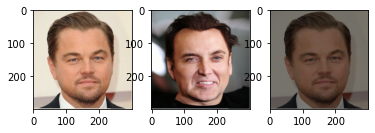

t =  0.25


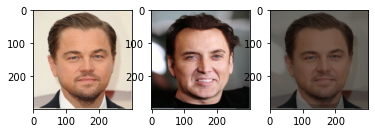

t =  0.5


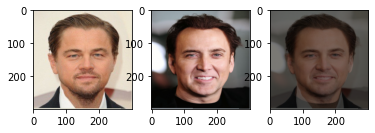

t =  0.75


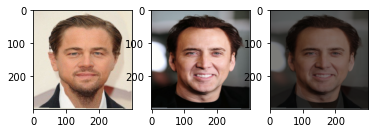

t =  0.95


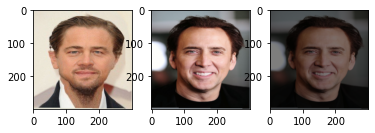

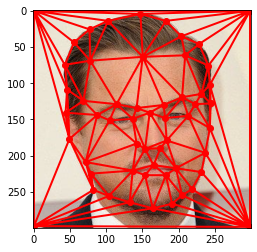

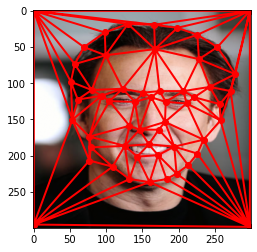

<Figure size 300x300 with 0 Axes>

In [6]:
# load in the keypoints and images select_keypoints.ipynb
f = open('face_correspondeces.pckl','rb')
image1,image2,pts1,pts2 = pickle.load(f)
f.close()

# add the image corners as additional points so that the
# triangles cover the whole image

# NOTE: I clicked on the corners when selecting my points, they are already included

#compute triangulation using mid-point between source and
#target to get trianglest that are good for both.
pts_mid = 0.5*(pts2+pts1)
trimesh = Delaunay(pts_mid.transpose())
#we only need the vertex indices so extract them from 
#the data structure returned by Delaunay
tri = trimesh.simplices.copy()

# generate the frames of the morph
movie = []
for t in np.arange(0,1,0.05):
    pts_warp = (1-t)*pts1+t*pts2
    warped_image1,tindex1 = warp(image1,pts1,pts_warp,tri)
    warped_image2,tindex2 = warp(image2,pts2,pts_warp,tri)
    blended_image= (warped_image1*(1-t)+warped_image2*t)/2.0
    movie.append(blended_image)
    if round(t,2) in [0.0,0.25,0.5,0.75,0.95]:
        print('t = ',round(t,2))
        fig = plt.figure()
        fig.add_subplot(1,3,1).imshow(warped_image1)
        fig.add_subplot(1,3,2).imshow(warped_image2)
        fig.add_subplot(1,3,3).imshow(blended_image)
        plt.show() 
    
# display original images and overlaid triangulation
fig1 = plt.figure()
plt.imshow(image1)
plt.triplot(pts1[0,:],pts1[1,:],tri,color='r',linewidth=2)
plt.plot(pts1[0,:],pts1[1,:],'ro')
plt.show()

fig2 = plt.figure()
plt.imshow(image2)
plt.triplot(pts2[0,:],pts2[1,:],tri,color='r',linewidth=2)
plt.plot(pts2[0,:],pts2[1,:],'ro')
plt.show()


# display as an animated movie (for your enjoyment)
HTML(display_movie(movie).to_jshtml()) 


---

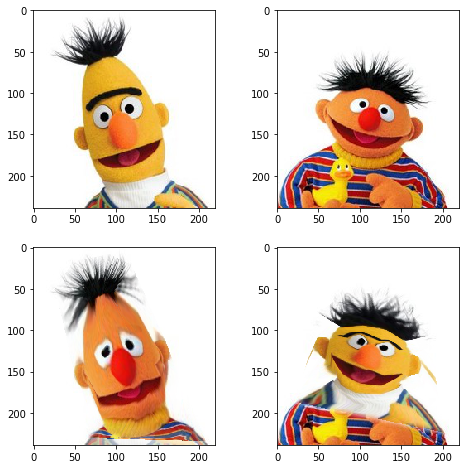

# Part 4 - Face Swapping 

We can use the same machinery of piecewise affine warping in order to swap faces.  To accomplish this, we first annotate two faces with keypoints as we did for morphing.  In this case the keypoints should only cover the 
face and *we won't add the corners of the image*. To place the face from image1 into image2, we call the
***warp*** function to generate the warped face image1_warped. In order to composite only the warped face pixels,
we need to create an alpha map. We can achieve this by using the ***tindex*** map returned from the warp function
to make a binary mask which is True inside the face region and False elsewhere. In order to minimize visible artifacts, we should utilize ***scipy.ndimage.gaussian_filter*** in order to feather the edge of the alpha mask. Once we have the feathered alpha map, we can composite the image1_warped face with the background from image2.

We then display 3 things:
1. the two source images with the keypoints overlayed,
2. the face from image1 composited into image2
3. the face from image2 composited into image1.


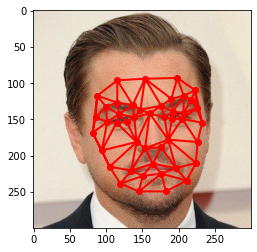

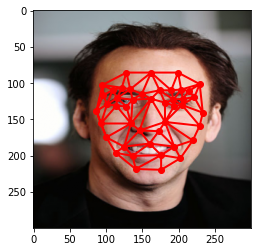

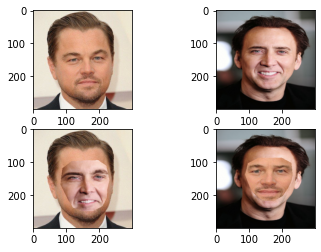

In [7]:
f = open('swap_correspondeces.pckl','rb')
image1,image2,pts1,pts2 = pickle.load(f)
f.close()

#compute triangulation using mid-point between source and
#target to get triangles that are good for both images.
pts_mid = 0.5*(pts2+pts1)
trimesh = Delaunay(pts_mid.transpose())

tri = trimesh.simplices.copy()

# put the face from image1 in to image2
(warped1,tindex1) = warp(image1,pts1,pts2,tri)
mask = np.where(tindex1<0, False, True)

alpha = gaussian_filter(mask,.25)*mask

# temp = alpha-0.5
# alpha = np.where(temp<0,np.where(mask==1,.000001,0),temp)/0.5

swap1 = np.zeros(image1.shape)
# do an alpha blend of the warped image1 and image2
swap1[:,:,0] = image2[:,:,0]*(1-alpha)+warped1[:,:,0]*alpha
swap1[:,:,1] = image2[:,:,1]*(1-alpha)+warped1[:,:,1]*alpha
swap1[:,:,2] = image2[:,:,2]*(1-alpha)+warped1[:,:,2]*alpha


#now do the swap in the other direction
(warped2,tindex2) = warp(image2,pts2,pts1,tri)
mask = np.where(tindex2<0, False, True)

alpha = gaussian_filter(mask,.25)*mask
swap2 = np.zeros(image1.shape)
# do an alpha blend of the warped image1 and image2
swap2[:,:,0] = image1[:,:,0]*(1-alpha)+warped2[:,:,0]*alpha
swap2[:,:,1] = image1[:,:,1]*(1-alpha)+warped2[:,:,1]*alpha
swap2[:,:,2] = image1[:,:,2]*(1-alpha)+warped2[:,:,2]*alpha
# display the images with the keypoints overlayed
fig1 = plt.figure()
plt.imshow(image1)
plt.triplot(pts1[0,:],pts1[1,:],tri,color='r',linewidth=2)
plt.plot(pts1[0,:],pts1[1,:],'ro')
plt.show()

fig2 = plt.figure()
plt.imshow(image2)
plt.triplot(pts2[0,:],pts2[1,:],tri,color='r',linewidth=2)
plt.plot(pts2[0,:],pts2[1,:],'ro')
plt.show()

# display the face swapping result
fig = plt.figure()
fig.add_subplot(2,2,1).imshow(image1)
fig.add_subplot(2,2,2).imshow(image2)
fig.add_subplot(2,2,3).imshow(swap2)
fig.add_subplot(2,2,4).imshow(swap1)
plt.show()